In [1]:
from fastai.collab import *
from fastai.tabular.all import *
set_seed(42)

## A First Look at the Data

[MovieLens](https://grouplens.org/datasets/movielens/) dataset contains tens of millions of movie rankings (a combination of a movie ID, a user ID, and a numeric rating), although I will just use a subset of 100,000 of them for our example. 

In [1]:
path = untar_data(URLs.ML_100k)

In [2]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user','movie','rating','timestamp'])
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


## Learning the Latent Factors

### Creating the DataLoaders

In [8]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [9]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [10]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.show_batch()

,user,title,rating
0,518,Richard III (1995),3
1,546,Star Wars (1977),5
2,264,"Adventures of Priscilla, Queen of the Desert, The (1994)",4
3,201,Kolya (1996),4
4,664,Dances with Wolves (1990),3
5,391,Jerry Maguire (1996),4
6,401,Beauty and the Beast (1991),2
7,771,Strictly Ballroom (1992),5
8,330,101 Dalmatians (1996),4
9,594,One Flew Over the Cuckoo's Nest (1975),4


In [12]:
n_users  = len(dls.classes['user'])
n_movies = len(dls.classes['title'])
n_factors = 5

user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

## Collaborative Filtering from Scratch

In [16]:
class Example:
    def __init__(self, a): self.a = a
    def say(self,x): return f'Hello {self.a}, {x}.'

In [17]:
ex = Example('Sylvain')
ex.say('nice to meet you')

'Hello Sylvain, nice to meet you.'

In [18]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return (users * movies).sum(dim=1)

In [19]:
x,y = dls.one_batch()
x.shape

torch.Size([64, 2])

In [20]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())

In [21]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.391418,1.281064,00:10
1,1.071581,1.059740,00:10
2,0.925082,0.955736,00:10
3,0.789137,0.877227,00:09
4,0.742079,0.862848,00:09


In [22]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return sigmoid_range((users * movies).sum(dim=1), *self.y_range)

In [23]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.978663,0.978617,00:09
1,0.858417,0.889232,00:09
2,0.657446,0.861478,00:09
3,0.473589,0.862058,00:08
4,0.372989,0.865978,00:08


In [24]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies, 1)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        res = (users * movies).sum(dim=1, keepdim=True)
        res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
        return sigmoid_range(res, *self.y_range)

In [25]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.943364,0.932987,00:08
1,0.824034,0.864243,00:08
2,0.586939,0.860469,00:09
3,0.409691,0.886897,00:08
4,0.303943,0.894082,00:08


### Weight Decay

In [27]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.964149,0.947329,00:08
1,0.853209,0.862615,00:09
2,0.734107,0.828079,00:08
3,0.595621,0.812455,00:08
4,0.490830,0.812497,00:08


### Creating Our Own Embedding Module

In [28]:
class T(Module):
    def __init__(self): self.a = torch.ones(3)

L(T().parameters())

(#0) []

In [29]:
class T(Module):
    def __init__(self): self.a = nn.Parameter(torch.ones(3))

L(T().parameters())

(#1) [Parameter containing:
tensor([1., 1., 1.], requires_grad=True)]

In [30]:
class T(Module):
    def __init__(self): self.a = nn.Linear(1, 3, bias=False)

t = T()
L(t.parameters())

(#1) [Parameter containing:
tensor([[-0.2714],
        [ 0.3146],
        [ 0.0898]], requires_grad=True)]

In [31]:
type(t.a.weight)

torch.nn.parameter.Parameter

In [32]:
def create_params(size):
    return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))

In [33]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = create_params([n_users, n_factors])
        self.user_bias = create_params([n_users])
        self.movie_factors = create_params([n_movies, n_factors])
        self.movie_bias = create_params([n_movies])
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors[x[:,0]]
        movies = self.movie_factors[x[:,1]]
        res = (users*movies).sum(dim=1)
        res += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]
        return sigmoid_range(res, *self.y_range)

In [34]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.946225,0.933384,00:09
1,0.866075,0.868197,00:09
2,0.704416,0.825246,00:10
3,0.604527,0.817444,00:10
4,0.499887,0.817852,00:09


## Interpreting Embeddings and Biases

In [35]:
movie_bias = learn.model.movie_bias.squeeze()
idxs = movie_bias.argsort()[:5]
[dls.classes['title'][i] for i in idxs]

['Children of the Corn: The Gathering (1996)',
 'Home Alone 3 (1997)',
 'Crow: City of Angels, The (1996)',
 'Mortal Kombat: Annihilation (1997)',
 'Cable Guy, The (1996)']

In [36]:
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['Titanic (1997)',
 "Schindler's List (1993)",
 'Shawshank Redemption, The (1994)',
 'Star Wars (1977)',
 'L.A. Confidential (1997)']

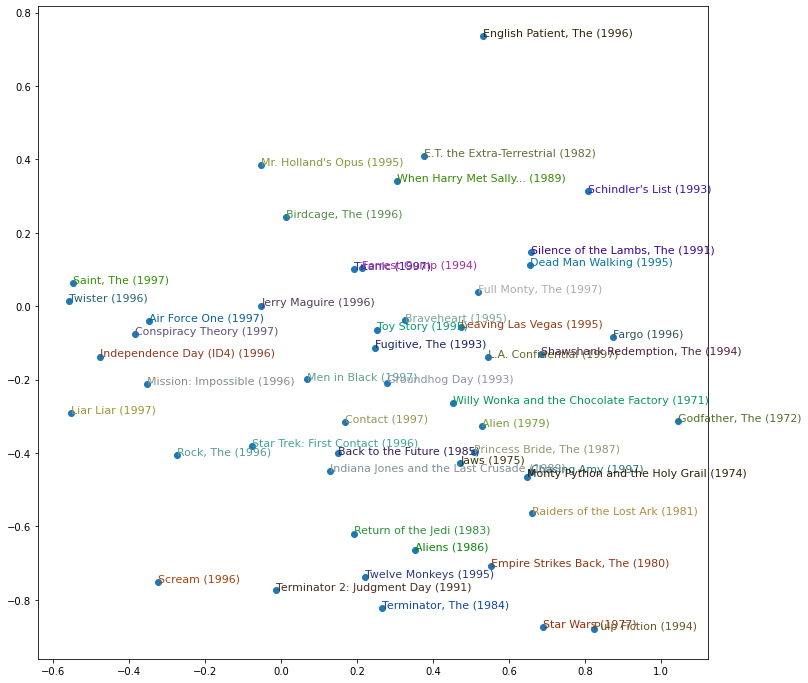

In [37]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
movie_w = learn.model.movie_factors[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
fac0,fac1,fac2 = movie_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

### Using fastai.collab

In [38]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

In [39]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.949029,0.931003,00:09
1,0.856821,0.868256,00:09
2,0.750694,0.823566,00:09
3,0.594716,0.811999,00:08
4,0.485535,0.812199,00:09


In [40]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1665, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1665, 1)
)

In [41]:
movie_bias = learn.model.i_bias.weight.squeeze()
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['Titanic (1997)',
 "Schindler's List (1993)",
 'Shawshank Redemption, The (1994)',
 'Casablanca (1942)',
 'Silence of the Lambs, The (1991)']

### Embedding Distance

In [42]:
movie_factors = learn.model.i_weight.weight
idx = dls.classes['title'].o2i['Silence of the Lambs, The (1991)']
distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
idx = distances.argsort(descending=True)[1]
dls.classes['title'][idx]

'8 Seconds (1994)'

## Deep Learning for Collaborative Filtering

In [43]:
embs = get_emb_sz(dls)
embs

[(944, 74), (1665, 102)]

In [44]:
class CollabNN(Module):
    def __init__(self, user_sz, item_sz, y_range=(0,5.5), n_act=100):
        self.user_factors = Embedding(*user_sz)
        self.item_factors = Embedding(*item_sz)
        self.layers = nn.Sequential(
            nn.Linear(user_sz[1]+item_sz[1], n_act),
            nn.ReLU(),
            nn.Linear(n_act, 1))
        self.y_range = y_range
        
    def forward(self, x):
        embs = self.user_factors(x[:,0]),self.item_factors(x[:,1])
        x = self.layers(torch.cat(embs, dim=1))
        return sigmoid_range(x, *self.y_range)

In [45]:
model = CollabNN(*embs)

In [46]:
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.01)

epoch,train_loss,valid_loss,time
0,0.966280,0.945594,00:12
1,0.919992,0.901902,00:14
2,0.851043,0.872732,00:11
3,0.801476,0.857287,00:12
4,0.766401,0.858708,00:11


In [47]:
learn = collab_learner(dls, use_nn=True, y_range=(0, 5.5), layers=[100,50])
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.993280,0.972087,00:13
1,0.932168,0.910090,00:13
2,0.860546,0.885197,00:12
3,0.808683,0.851108,00:15
4,0.727542,0.849919,00:14
